# A joint model CAR (model 1) 
# With Crossvalidation
## Two independent processes
 $$ [P , S ] = [P ] [ S ] $$

In [3]:
## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')

In [4]:
rm(list=ls())                                                                                     
source("init_data.R")                                                                             
# load the building function                                                                      
source("joint.binomial.bymCARModel1.R")

Cross validation of CAR models is not straight forward due to its spatial structure (lattice). 
The approach for this would be with data augmentation.
removing the value for validate.data and change it o NA.

After the model, I'll extract the resulting probability and perform a simple ROC curve.


In [5]:
## Preeliminary results 
ntot = length(DataFrame$sample)
npresence_1 = length(na.omit(DataFrame$species[DataFrame$species == 1])) / ntot*100
nsample_1 = length(na.omit(DataFrame$sample[DataFrame$sample == 1]))/ntot*100
npresence_0 = length(na.omit(DataFrame$species[DataFrame$species == 0]))/ntot*100
nsample_0 = length(na.omit(DataFrame$sample[DataFrame$sample == 0]))/ntot*100
n_miss_presence = sum(is.na(DataFrame$species))/ntot*100
n_miss_sample = sum(is.na(DataFrame$sample))/ntot*100
cbind(npresence_0,npresence_1,nsample_0,nsample_1,n_miss_presence,n_miss_sample)

npresence_0,npresence_1,nsample_0,nsample_1,n_miss_presence,n_miss_sample
63.02956,8.399015,10.59113,71.42857,28.57143,17.9803


In [3]:
## MCMC parameters burnin and sample to be consistent with the other models
#n.sample = 10000                                                                                  
#burnin=10000                                                                                      
#postburnin = burnin +1000                                                                         

n.sample = 10000                                                                                 
burnin=5000                                                                                      
postburnin = burnin +1000                                                                         


thin = 1                                                                                          
verbose = TRUE                           

## Make ROC curve
library(pROC)
library('caret')
#trains = createFolds(y = DataFrame$species, k=7, returnTrain = TRUE)

nonas = which(! is.na(DataFrame$species) )
Y_withoutNA = DataFrame$species[nonas]
validate = createFolds(y = Y_withoutNA, k=7, returnTrain = FALSE)


DataFrame$presences <- DataFrame$species

l <- list()
i = 1
DataFrame$predicted_values_CV <- NA
DataFrame$predicted_valuesBernoulli <- NA

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [4]:
names(DataFrame)

[1] "X"                         "LUCA"                     
 [3] "Plantae"                   "Pinophyta"                
 [5] "Abies"                     "cellids"                  
 [7] "Disttoroadm"               "Elevationm"               
 [9] "MaxTempm"                  "MeanTempm"                
[11] "MinTempm"                  "Populationm"              
[13] "Precipitationm"            "SolarRadiationm"          
[15] "VaporPresm"                "WindSpm"                  
[17] "Longitude"                 "Latitude"                 
[19] "wwfmhtnum"                 "wwfmhtnam"                
[21] "covid"                     "name"                     
[23] "covid2"                    "tipos"                    
[25] "geometry"                  "sample"                   
[27] "species"                   "presences"                
[29] "predicted_values_CV"       "predicted_valuesBernoulli"

In [5]:

formula_sample =  sample ~ Disttoroadm + Populationm
formula_presence = species ~ Elevationm + Precipitationm

for (fold in validate) {
    
    observed.presences <- DataFrame$species[fold]
    ## Substitue by NA
    DataFrame$species[fold] <- NA
    results  <- joint.binomial.bymCARModel1(formula_S = formula_sample, 
                                        formula_P = formula_presence,
                                        n.sample=n.sample,
                                        data = DataFrame,
                                        burnin=burnin,
                                        postburnin=postburnin,
                                        thin=thin,
                                        verbose=TRUE) 

    DataFrame$species <- DataFrame$presences
    ## Return original values
    DataFrame$predicted_values_CV[fold] <- results$fitted.values[fold]
    predicted.probability = results$fitted.values[fold]
    
    ## Generate Bernoulli sample [ Only for the fold data set]
    print("Generating bernoulli sampling...")

    post.joint = data.frame(results$samples$fitted.joint[fold])

    ptot <- post.joint %>% mutate_all(function(p) rbernoulli(1,p))

    sumpt <- colSums(ptot)

    nsamples = dim(ptot)[1]
    

    ProbPS <- sumpt / nsamples
    
    DataFrame$predicted_valuesBernoulli[fold] <- ProbPS
    
    
    pROC_obj <- roc(observed.presences,predicted.probability)

    l[[i]] <- pROC_obj
    i = i + 1
}

Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  53 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  52.9 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"
[1] "Generating bernoulli sampling..."


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  53.8 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  52.2 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"
[1] "Generating bernoulli sampling..."


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  54.4 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  53 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"
[1] "Generating bernoulli sampling..."


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  53 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  52.3 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"
[1] "Generating bernoulli sampling..."


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  54.7 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  53.2 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"
[1] "Generating bernoulli sampling..."


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  53.6 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  51.6 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"
[1] "Generating bernoulli sampling..."


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  54.1 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  53.7 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"
[1] "Generating bernoulli sampling..."


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”

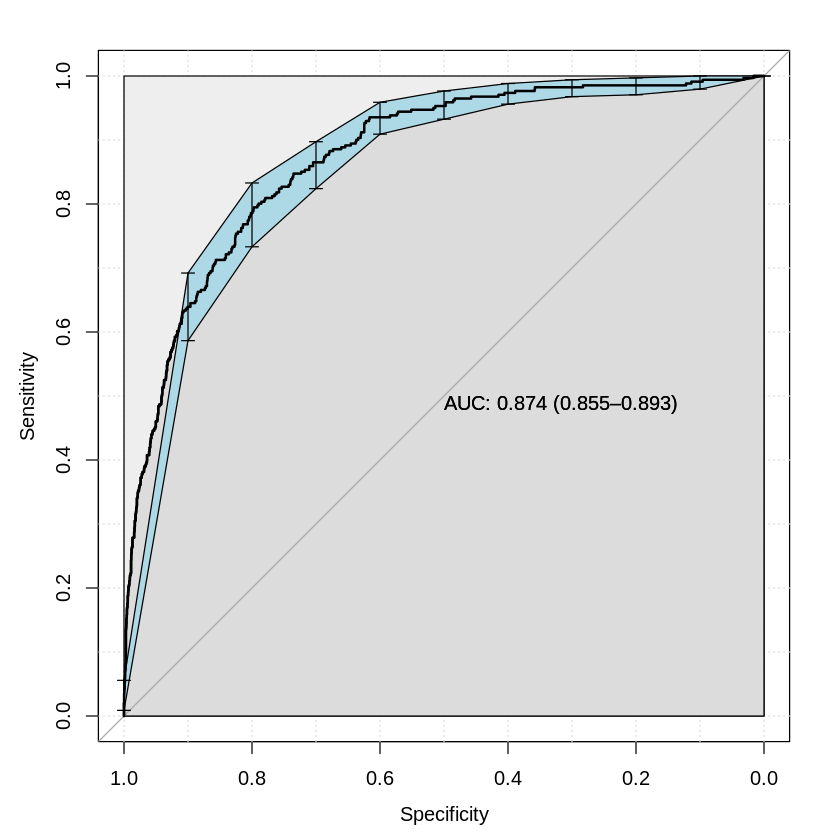

In [7]:
pROC_obj <- roc(DataFrame$presences,DataFrame$predicted_values_CV,
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE)
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”

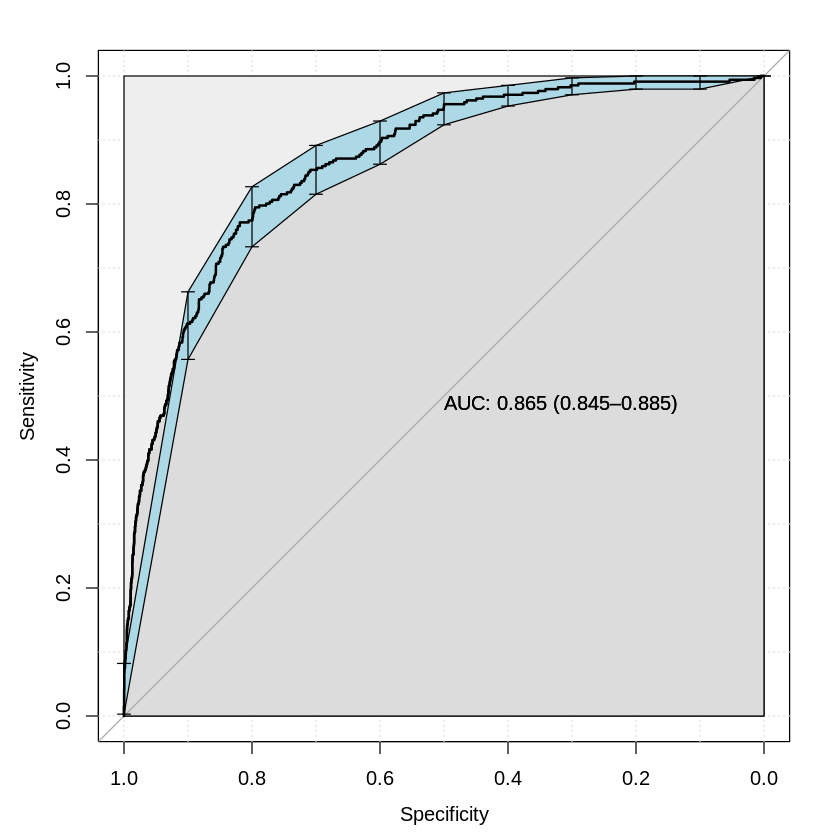

In [11]:
pROC_obj <- roc(DataFrame$presences,DataFrame$predicted_values_CV,
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE)
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")



## Generate results

In [11]:
formula_sample =  sample ~ Disttoroadm + Populationm
formula_presence = species ~ Elevationm + Precipitationm
## Complete model
results  <- joint.binomial.bymCARModel1(formula_S = formula_sample, 
                                        formula_P = formula_presence,
                                        n.sample=n.sample,
                                        data = DataFrame,
                                        burnin=burnin,
                                        postburnin=postburnin,
                                        thin=thin,
                                        verbose=TRUE)

Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  53.5 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  51.9 seconds.
Sampling from the joint model 10000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"


In [12]:
library(coda)

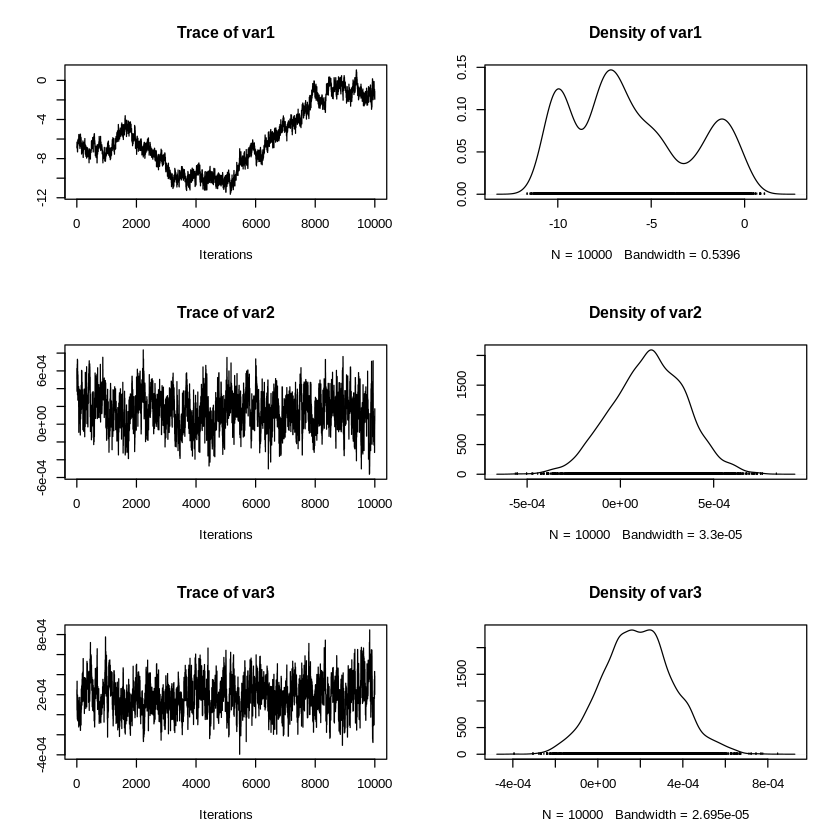

In [13]:
plot(results$P$samples$beta)

In [14]:
## without NA'sin Y
results$summary.results

DIC           p.d          WAIC           p.w          LMPL 
    3421.2063      986.8115     3487.4308      807.7088    -1921.0294 
loglikelihood 
    -723.7917

In [28]:
## with NA's in Y
results$summary.results

DIC           p.d          WAIC           p.w          LMPL 
    3517.6101      896.7166     3577.0343      752.2025    -1895.7591 
loglikelihood 
    -862.0884

In [29]:
## with no NA's in Y
results$summary.results

DIC           p.d          WAIC           p.w          LMPL 
    3517.6101      896.7166     3577.0343      752.2025    -1895.7591 
loglikelihood 
    -862.0884

In [ ]:
results$summary.results

In [15]:
results$S$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),5.7310,3.3187,6.6510,10000,61,5.8,-9.5
Disttoroadm,-0.0002,-0.0004,-0.0001,10000,61,698.5,5.3
Populationm,0.0000,-0.0001,0.0002,10000,61,1586.7,-1.6
tau2,6.5012,3.5715,11.1250,10000,100,8.0,-3.4
sigma2,0.2779,0.1396,1.0679,10000,100,3.4,-0.9


In [16]:
results$P$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),-6.7040,-10.6798,-0.2019,10000,64.3,2.3,-1.7
Elevationm,0.0002,-0.0002,0.0005,10000,64.3,234.5,3.6
Precipitationm,0.0002,-0.0001,0.0005,10000,64.3,244.7,0.4
tau2,27.0630,19.1165,42.0452,10000,100.0,13.5,3.0
sigma2,0.1107,0.0285,2.6562,10000,100.0,4.8,-1.5


In [30]:
results$P$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),-3.5720,-5.9809,-0.9618,10000,63.7,9.4,-2.3
Elevationm,0.0001,-0.0002,0.0005,10000,63.7,287.2,0.3
MeanTempm,-0.0005,-0.0009,0.0000,10000,63.7,109.7,1.3
tau2,19.4756,13.1363,39.6048,10000,100.0,8.0,-1.3
sigma2,0.0641,0.0280,0.1470,10000,100.0,4.6,3.3


In [18]:
meanfitted = results$fitted.values

In [31]:
fitted_samples = cbind(results$S$samples$fitted,results$P$samples$fitted)

post.sample_p = data.frame(results$S$samples$fitted)
post.presence_p = data.frame(results$P$samples$fitted)
post.joint = data.frame(results$samples$fitted.joint)

pss  <- post.sample_p %>% mutate_all(function(p) rbernoulli(1,p))
pps <- post.presence_p %>% mutate_all(function(p) rbernoulli(1,p))
ptot <- post.joint %>% mutate_all(function(p) rbernoulli(1,p))

sumpt <- colSums(ptot)
sumps <- colSums(pss)
sumpp <- colSums(pps)

nsamples = dim(ptot)[1]
print(nsamples)

ProbPS <- sumpt / nsamples
ProbP <- sumpp / nsamples
ProbS <- sumps / nsamples
                                  

[1] 10000


In [39]:
## Compute independent joint distribution
library(boot)

fitted_presences = apply(results$P$samples$fitted,MARGIN=1,identity)
fitted_sample = apply(results$S$samples$fitted,MARGIN=1,identity)
fitted_total = apply(results$samples$fitted,MARGIN=1,identity)

re_presence = apply(results$P$samples$psi,MARGIN=1,identity)
re_sample = apply(results$S$samples$psi,MARGIN=1,identity)

In [40]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}

P = getUpperLowerCI(fitted_presences,prefix = 'P')
S = getUpperLowerCI(fitted_sample,prefix = 'S')
PS = getUpperLowerCI(fitted_total,prefix = 'PS')
Gp = getUpperLowerCI(re_presence,prefix = 'Gp')
Gs = getUpperLowerCI(re_sample,prefix = 'Gs')



## Compute ROC with PS to see if it improves


In [14]:
DataFrame$predicted_values_CV

[1] 0.0100092153 0.0037514855 0.0012740532 0.0025861249 0.0034312680
   [6] 0.0009660166 0.0042144586 0.0149364423 0.0054167939 0.0063974280
  [11] 0.0025688480 0.0024484146 0.0014994281 0.0011160441 0.0005519779
  [16] 0.0006517654 0.0041358300 0.0156783768 0.0020640475 0.0026203934
  [21] 0.0020163269 0.0016447204 0.0011020640 0.0027969625 0.0026710687
  [26] 0.0004851540 0.0016541902 0.0012136680 0.0011877366 0.0061200202
  [31] 0.0107516185 0.0045010154 0.0023386101 0.0047352269 0.0029109368
  [36] 0.0030420002 0.0023412976 0.0003069204 0.0017150703 0.0019508533
  [41] 0.0024544956 0.0014603088 0.0005071433 0.0056700781 0.0115717978
  [46] 0.0064740446 0.0033045347 0.0019521769 0.0032656239 0.0023152798
  [51] 0.0033284083 0.0027456012 0.0026160092 0.0012133466 0.0005051445
  [56] 0.0036618215 0.0043599173 0.0031257729 0.0039882481 0.0043797644
  [61] 0.0581386146 0.0019764902 0.0019345853 0.0028970307 0.0015444965
  [66] 0.0006457869 0.0021061196 0.0007491472 0.0033539665 0.0028087803
  [71] 0.0016387722 0.0004031340 0.0018489197 0.0041659968 0.0026914631
  [76] 0.0010580113 0.0054755166 0.0056438577 0.0020279420 0.0015325723
  [81] 0.0027858170 0.0019886358 0.0025199411 0.0036317723 0.0019017709
  [86] 0.0004173999 0.0003626430 0.0014464102 0.0018089474 0.0006061023
  [91] 0.0009412528 0.0011186620 0.0011163601 0.0019570467 0.0029318643
  [96] 0.0028588553 0.0002544152 0.0098984214 0.0067247979 0.0011012218
 [101] 0.0010094953 0.0013504226 0.0123554870 0.0013983070 0.0006670763
 [106] 0.0034342784 0.0016748851 0.0017312896 0.0003438087 0.0016075027
 [111] 0.0020643327 0.0016512079 0.0009184213 0.0014716328 0.0015082695
 [116] 0.0032980732 0.0029753969 0.0035932146 0.0066117052 0.0006738250
 [121] 0.0203874491 0.0046389751 0.0031740408 0.0015710248 0.0017894394
 [126] 0.0014645919 0.0022647816 0.0022182583 0.0022499109 0.0032016725
 [131] 0.0028885638 0.0018724524 0.0010740369 0.0012029976 0.0013556216
 [136] 0.0021861138 0.0030676231 0.0028901384 0.0045619649 0.0046804305
 [141] 0.0072800759 0.0025825695 0.0103760362 0.0140112047 0.0294989702
 [146] 0.0038536259 0.0032628050 0.0017315797 0.0012610929 0.0026713472
 [151] 0.0018371045 0.0016799423 0.0017810244 0.0017674420 0.0014919401
 [156] 0.0012664930 0.0019084721 0.0011892077 0.0017566699 0.0007847506
 [161] 0.0002834379 0.0025015172 0.0035521285 0.0045701932 0.0068786759
 [166] 0.0139424519 0.0006030366 0.0202026663 0.0004245609 0.0018749910
 [171] 0.0319551415 0.0107531252 0.0104539341 0.0027364816 0.0013862120
 [176] 0.0018503751 0.0021188108 0.0029286501 0.0029879940 0.0034924568
 [181] 0.0025835906 0.0008725806 0.0024941268 0.0018284721 0.0031348418
 [186] 0.0006942194 0.0018949561 0.0020649055 0.0029662825 0.0038072399
 [191] 0.0051760702 0.0078041954 0.0155671045 0.0269415424 0.0006175398
 [196] 0.0008956945 0.0093368414 0.0310082372 0.0133625310 0.0096376644
 [201] 0.0093857113 0.0122705447 0.0036795934 0.0034181474 0.0025051998
 [206] 0.0043022471 0.0044374991 0.0036513441 0.0035148810 0.0019118780
 [211] 0.0027188186 0.0007515151 0.0004948239 0.0006629360 0.0014812795
 [216] 0.0018341972 0.0020622945 0.0003050280 0.0018941855 0.0032586185
 [221] 0.0054313090 0.0051913979 0.0059095025 0.0063993467 0.0053016420
 [226] 0.0205388341 0.1495713144 0.0469975726 0.0279066784 0.0073618551
 [231] 0.0093869371 0.0058621653 0.0057047127 0.0156771124 0.0046764436
 [236] 0.0055883693 0.0046735196 0.0063153230 0.0042781547 0.0019347778
 [241] 0.0035110451 0.0031810950 0.0013224713 0.0022351288 0.0014338007
 [246] 0.0013288895 0.0013641399 0.0015544286 0.0038520800 0.0037550556
 [251] 0.0049101376 0.0064465286 0.0054104971 0.0002165087 0.0046879697
 [256] 0.0069898715 0.4701930356 0.1803710085 0.0322983495 0.0300411714
 [261] 0.0239126346 0.0107487311 0.0159205030 0.0103474607 0.0073285613
 [266] 0.0065159159 0.0071689584 0.0061339801 0.0028753431 0.0031492251
 [271] 0.0018686807 0.0041104306 0.0021558888 0.0015540990 0.0020016254
 [276] 0.0019679882 0.0002415924 0.00293494

In [ ]:
pROC_obj <- roc(DataFrame$presences,DataFrame$predicted_values_CV,
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE)
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")

In [41]:
## save to posterity
# Save output sample to display in python
## Save the complete chain trace for analysing in Python,
#TDF = read.csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Order it according to the id of the cell
## This is important because the adjancy matrix rows need to be the same

## No needed because DataFrame object already loaded and without no-neighbour (i.e. same size as fitted values)
#TDF = TDF[order(TDF$cell_ids),]
TDF = DataFrame[order(DataFrame$cellids),]

In [43]:
chain = cbind(TDF$cellids,Gp,Gs,P,S,PS,ProbPS,ProbP,ProbS)
file_ = '/outputs/presence_only_models/modelCAR_model1_fitted2.csv'
write.csv(chain,file_)